In [1]:
import numpy as np
import tensorflow as tf
import csv
import h5py
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

In [2]:
def load_data():
    
    ### import training data from csv files
    main_file="labels.csv"
    main_label=np.loadtxt(main_file, delimiter=",")
    main_label=main_label.reshape((main_label.shape[0],1))
    m=main_label.shape[0]
    
    # changing the labels to digits starting from 0
    labels=np.zeros((m,1), dtype="int")
    num_class=int(0)
    current_bus=main_label[0]
    bus_reference={str(num_class): current_bus} # dictionary containing original labels

    for i in range(m):
        if main_label[i]!=current_bus:
            num_class+=int(1)
            current_bus=main_label[i]
            bus_reference[str(num_class)]=current_bus
    
        labels[i]=num_class
    labels=labels.astype(int)
    
    main_file="features.csv"
    main_features=np.loadtxt(main_file, delimiter=",")
    
    DATA={'labels': labels,
          'main_features': main_features}
    num_class+=1
    
    return DATA, bus_reference, num_class

In [3]:
def select_features(selected_buses, DATA):
    
    # U can select what features to use for training
    main_features=DATA['main_features']
    m=len(selected_buses)
    n=DATA['main_features'].shape[0]
    features=main_features[:,selected_buses]
    
    return features

In [4]:
def make_onehot(DATA, num_class):
    
    #Convert labels to onehot
    one_hot=np.zeros((DATA['labels'].shape[0], num_class))
    for i,j in enumerate(DATA['labels']):
        one_hot[i,j]=1
        
    return one_hot

In [5]:
def split_dataset(features, labels, test_percentage):
    
    #Split data to training/test sets
    indices=np.random.permutation(features.shape[0])
    num_test=int(features.shape[0]*test_percentage)
    test_index, train_index=indices[:num_test], indices[num_test:]
    
    test_features, train_features=features[test_index,:], features[train_index,:]
    test_labels, train_labels=labels[test_index,:], labels[train_index,:]
    
    dataset={'train_labels':   train_labels.T,
             'train_features': train_features.T,
             'test_labels':    test_labels.T,
             'test_features':  test_features.T}
    
    return dataset

In [6]:
def initialize_weights(num_feature, num_class):
    
    """
    Initialize weights:
    num_layer=3
    layer1,   layer2,   layer3=num_class
                        W1 : [layer1, num_feature],   b1 : [layer1, 1]
                        W2 : [layer2, layer1],        b2 : [layer2, 1]
                        W3 : [num_class, layer2],     b3 : [num_class, 1]
                        
    weight is a dictionary that contains all weigth/bias matrices
    """
    layer1=40
    layer2=20         
        
    W1 = tf.get_variable("W1", [layer1,num_feature], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [layer1,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [layer2,layer1], initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", [layer2,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [num_class,layer2], initializer = tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", [num_class,1], initializer = tf.zeros_initializer())

    weights = {"W1": W1,
               "b1": b1,
               "W2": W2,
               "b2": b2,
               "W3": W3,
               "b3": b3}
    
    return weights

In [7]:
def forward_propagation(X, weights):
    
    #Three layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX
    W1 = weights['W1']
    b1 = weights['b1']
    W2 = weights['W2']
    b2 = weights['b2']
    W3 = weights['W3']
    b3 = weights['b3']
            
    L1 = tf.add(tf.matmul(W1,X), b1)                               
    A1 = tf.nn.relu(L1)                                             
    L2 = tf.add(tf.matmul(W2,A1), b2)                               
    A2 = tf.nn.relu(L2)                                              
    Lf = tf.add(tf.matmul(W3,A2), b3)  
    
    return Lf

In [8]:
def compute_cost(Lf, Y):

    logits = tf.transpose(Lf)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))
    
    return cost

In [9]:
def model(dataset, num_feature, num_class, learning_rate, num_epochs):
   
    X_train=dataset['train_features']
    Y_train=dataset['train_labels']
    X_test=dataset['test_features']
    Y_test=dataset['test_labels']
    
    ops.reset_default_graph()                         
    size_x_1 = X_train.shape[0]                          
    size_y_1 = Y_train.shape[0]                   
    costs = []                                        
    
    # Create Placeholders for X and Y
    X = tf.placeholder(tf.float32, [size_x_1, None])
    Y = tf.placeholder(tf.float32, [size_y_1, None])
    
    # Initialize parameters
    weights = initialize_weights(num_feature, num_class)
    
    # Forward propagation: 
    Lf = forward_propagation(X, weights)
    
    # Cost function: 
    cost = compute_cost(Lf, Y)
    
    # Backpropagation: Use either adam or gradient decent for updating weights
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
            epoch_cost = 0.0                      
            _ , epoch_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
            
            if epoch % 1000 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                costs.append(epoch_cost)               
                
        # plot cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations * 1000')
        plt.show()

        weights = sess.run(weights)
        print ("Fault locator model is trained!")

        # Calculate the accuracy of the trained model
        correct_prediction = tf.equal(tf.argmax(Lf), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        # calculate and plot the confusion matrix
        ConfMat=np.zeros((num_class, num_class))
        pred=np.argmax(Lf.eval({X: X_test, Y: Y_test}), axis=0)
        for i,j in zip(pred, np.argmax(Y_test, axis=0)):
            ConfMat[j,i]+=1
        print(ConfMat) 
        plt.matshow(ConfMat)
        plt.colorbar()
        
        return weights

In [10]:
DATA, bus_reference, num_class=load_data()
#print(DATA['labels'].shape)
#print(DATA['main_features'].shape)

In [11]:
selected_buses=[1, 2, 3, 11, 27, 29, 50, 57, 74, 89]
features=select_features(selected_buses, DATA)
#print(features.shape)

In [12]:
labels=make_onehot(DATA, num_class)
#print(labels.shape)

In [13]:
dataset=split_dataset(features, labels, 0.05)
#print(dataset['train_features'].shape)
#print(dataset['test_features'].shape)

W0824 16:52:47.542867 14360 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Cost after epoch 0: 3.293858
Cost after epoch 1000: 1.539088
Cost after epoch 2000: 1.096882
Cost after epoch 3000: 0.838951
Cost after epoch 4000: 0.711658
Cost after epoch 5000: 0.627730
Cost after epoch 6000: 0.571213
Cost after epoch 7000: 0.529680
Cost after epoch 8000: 0.497979
Cost after epoch 9000: 0.469640
Cost after epoch 10000: 0.443815
Cost after epoch 11000: 0.423205
Cost after epoch 12000: 0.405764
Cost after epoch 13000: 0.390004
Cost after epoch 14000: 0.375364
Cost after epoch 15000: 0.362260
Cost after epoch 16000: 0.349467
Cost after epoch 17000: 0.337654
Cost after epoch 18000: 0.326593
Cost after epoch 19000: 0.316146


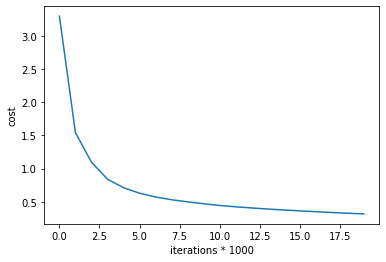

Model is trained!
Train Accuracy: 0.9635627
Test Accuracy: 0.95076925
[[19.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 16.  8.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 15.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 28.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 19.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 21.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. 27.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 27.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 29.  0.  0.  0.  0.  0. 

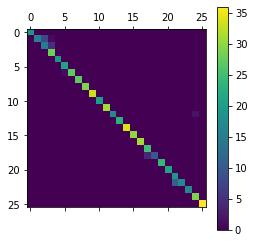

In [14]:
num_feature=len(selected_buses)
weights=model(dataset, num_feature, num_class, 0.00025, 100000)